In [4]:
import os
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [ ]:
class TargetTrialEmulator:
    def __init__(self, estimand="ITT"):
        self.estimand = estimand
        self.weights = None
        self.model = None
        self.expanded_data = None
        
    def prepare_data(self, data_path):
        self.data = pd.read_csv(data_path)
        self.data['age_s'] = self.data['age'] + self.data['period']/12
        return self
    
    def calculate_weights(self):
        # Treatment switching weights (PP only)
        if self.estimand == "PP":
            switch_num = LogisticRegression()
            switch_num.fit(self.data[['age']], self.data['treatment'])
            numer = switch_num.predict_proba(self.data[['age']])[:,1]
            
            switch_den = LogisticRegression()
            switch_den.fit(self.data[['age', 'x1', 'x3']], self.data['treatment'])
            denom = switch_den.predict_proba(self.data[['age', 'x1', 'x3']])[:,1]
            
            switch_weights = numer / denom
        else:
            switch_weights = np.ones(len(self.data))
            
        # Censoring weights
        censor_model = LogisticRegression()
        censor_model.fit(self.data[['x2', 'x1']], self.data['censored'])
        censor_probs = censor_model.predict_proba(self.data[['x2', 'x1']])[:,0]
        censor_weights = 1 / censor_probs
        
        # Combine weights
        self.weights = switch_weights * censor_weights
        return self
    
    def expand_trials(self, chunk_size=500):
        # Simplified trial expansion (conceptual)
        expanded = []
        for period in self.data['period'].unique():
            period_data = self.data[self.data['period'] == period].copy()
            period_data['trial_period'] = period
            expanded.append(period_data)
        
        self.expanded_data = pd.concat(expanded)
        return self
    
    def fit_msm(self):
        # Winsorize weights
        q99 = np.quantile(self.weights, 0.99)
        self.expanded_data['weights'] = np.minimum(self.weights, q99)
        
        # Fit Cox PH model
        self.model = CoxPHFitter()
        self.model.fit(self.expanded_data[['treatment', 'x2', 'period', 'outcome', 'weights']],
                      duration_col='period',
                      event_col='outcome',
                      weights_col='weights',
                      robust=True 
        )
        return self
    
    def predict_survival(self, periods=10):
        prediction_data = self.expanded_data[self.expanded_data['period'] == 1].copy()
        return self.model.predict_survival_function(prediction_data)
    
    def plot_survival(self):
        self.model.plot()
        plt.title(f"{self.estimand} Survival Curves")
        plt.show()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1067098060.py, line 59)

Running ITT Analysis...

ITT Model Summary:


C:\Users\edoua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


<lifelines.CoxPHFitter: fitted with 879.559 total observations, 753.912 right-censored observations>
             duration col = 'period'
                event col = 'outcome'
              weights col = 'weights'
      baseline estimation = breslow
   number of observations = 879.559
number of events observed = 125.647
   partial log-likelihood = -746.85
         time fit was run = 2025-03-08 12:12:21 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
treatment -0.10      0.90      0.18           -0.45            0.25                0.64                1.28
x2         0.08      1.09      0.09           -0.10            0.26                0.91                1.30

           cmp to     z    p  -log2(p)
covariate                             
treatment    0.00 -0.58 0.56      0.83
x2           0.00  0.90 0.37      1.45
---
Concordance = 0.54
Partial AIC = 1497.70
log-likelihood ratio test = 1.12 on 2 df
-log2(p) of ll-ratio test = 0.81

None

Running PP Analysis...

PP Model Summary:


C:\Users\edoua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


<lifelines.CoxPHFitter: fitted with 879.604 total observations, 753.845 right-censored observations>
             duration col = 'period'
                event col = 'outcome'
              weights col = 'weights'
      baseline estimation = breslow
   number of observations = 879.604
number of events observed = 125.759
   partial log-likelihood = -747.53
         time fit was run = 2025-03-08 12:12:21 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
treatment -0.10      0.90      0.18           -0.45            0.25                0.63                1.28
x2         0.08      1.09      0.09           -0.10            0.26                0.91                1.30

           cmp to     z    p  -log2(p)
covariate                             
treatment    0.00 -0.59 0.56      0.84
x2           0.00  0.90 0.37      1.44
---
Concordance = 0.54
Partial AIC = 1499.05
log-likelihood ratio test = 1.12 on 2 df
-log2(p) of ll-ratio test = 0.81

None

Generating Survival Predictions...


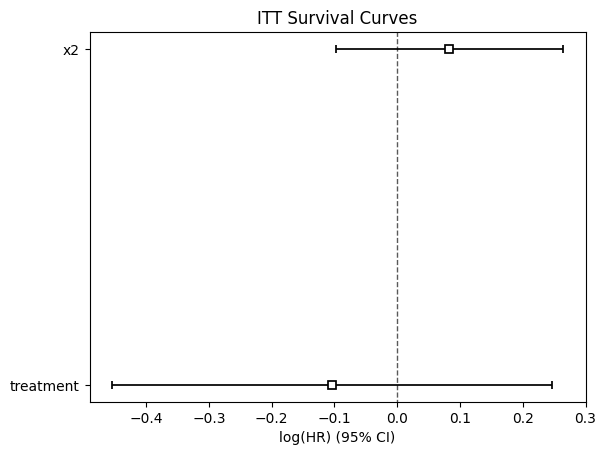

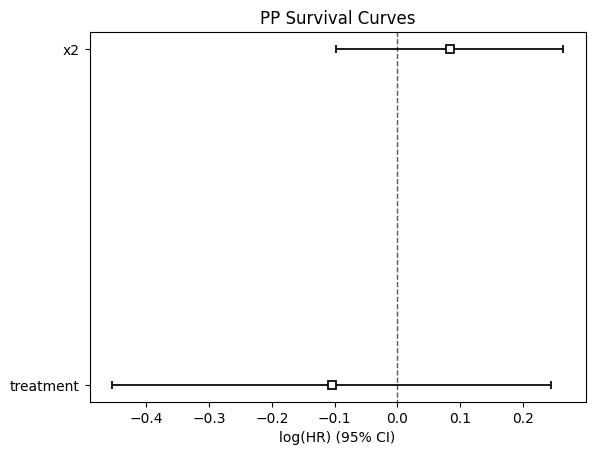

In [ ]:
print("Running ITT Analysis...")
emulator_itt = TargetTrialEmulator(estimand="ITT")
emulator_itt.prepare_data("data_censored.csv")
emulator_itt.calculate_weights()
emulator_itt.expand_trials()
emulator_itt.fit_msm()

print("\nITT Model Summary:")
print(emulator_itt.model.print_summary())

# Initialize and run PP analysis
print("\nRunning PP Analysis...")
emulator_pp = TargetTrialEmulator(estimand="PP")
emulator_pp.prepare_data("data_censored.csv")
emulator_pp.calculate_weights()
emulator_pp.expand_trials()
emulator_pp.fit_msm()

print("\nPP Model Summary:")
print(emulator_pp.model.print_summary())

# Generate predictions and plots
print("\nGenerating Survival Predictions...")
emulator_itt.plot_survival()
emulator_pp.plot_survival()

# Save model outputs
emulator_itt.expanded_data.to_csv("itt_expanded_data.csv", index=False)
emulator_pp.expanded_data.to_csv("pp_expanded_data.csv", index=False)